<a href="https://www.kaggle.com/code/thirumani/predicting-bigg-boss-marathi-season-4-winner?scriptVersionId=107174403" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Predicting Marathi Bigg Boss (बिग बॉस मराठी) Season 4 Winner

## Dataset https://www.kaggle.com/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

In [1]:
import datetime
print("Notebook was last executed on:", datetime.date.today().strftime("%Y-%b-%d"))

Notebook was last executed on: 2022-Oct-04


### Importing Required Python Libraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [3]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 159422 Oct  4 11:44 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 914 rows and 26 columns in the dataset


## Exploratory Data Analysis (EDA)

In [4]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15.0,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3.0,0.0,0.0,NaN,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15.0,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1.0,0.0,0.0,NaN,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15.0,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1.0,0.0,0.0,NaN,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15.0,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1.0,0.0,0.0,NaN,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15.0,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6.0,0.0,0.0,NaN,1.0,0.0


In [5]:
bigg_boss.tail(10).T

,904,905,906,907,908,909,910,911,912,913
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,4,4,4,4,4,4,4,4,4,4
Name,Naveen Arakkal,Nimisha,Robin Radhakrishnan,Ronson Vincent,Shalini Nair,Sooraj Thelakkad,Suchithra Nair,Manikandan Thonnakkal,Riyas Salim,Vinay Madhav
Profession,Soap Actor,Model,Doctor,Soap Actor,Video Jockey,Actor,Soap Actress,Social Media Star,Social Media Star,Social Media Star
Gender,Male,Female,Male,Male,Female,Male,Female,Male,Male,Male
Entry Date,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,NaN,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,5.0,7.0,10.0,13.0,3.0,14.0,9.0,4.0,14.0,12.0
Wild Card,No,No,No,No,No,No,No,Yes,Yes,Yes
Season Length,98,98,98,98,98,98,98,98,98,98


In [6]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
656,Tamil,2,Ponnambalam,Actor,Male,17-Jun-18,NaN,8.0,No,105,17.0,17-Jun-18,30-Sep-18,Kamal Haasan,NaN,0,Star Vijay,8.20,Tamil Nadu,No,6.0,0.0,0.0,NaN,0.0,0.0
736,Marathi,1,Aarti Solanki,Comedian,Female,15-Apr-18,NaN,1.0,No,98,18.0,15-Apr-18,22-Jul-18,Mahesh Manjrekar,NaN,0,Colors Marathi,NaN,Maharashtra,No,1.0,0.0,0.0,NaN,0.0,0.0
195,Hindi,11,Priyank Sharma,Model,Male,01-Oct-17,NaN,13.0,No,106,19.0,01-Oct-17,14-Jan-18,Salman Khan,NaN,0,Colors,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,8.0,1.0,0.0,NaN,0.0,0.0
15,Hindi,2,Ahsaan Qureshi,Comedian,Male,17-Aug-08,NaN,9.0,No,98,15.0,17-Aug-08,22-Nov-08,Shilpa Shetty,NaN,0,Colors,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1.0,0.0,0.0,NaN,0.0,0.0
713,Tamil,5,Priyanka Deshpande,TV Anchor,Female,03-Oct-21,NaN,15.0,No,105,20.0,03-Oct-21,16-Jan-22,Kamal Haasan,Ramya Krishnan,0,Star Vijay,18.60,Tamil Nadu,No,10.0,0.0,1.0,9.0,1.0,0.0
256,Hindi,14,Shehzad Deol,Model,Male,03-Oct-20,18-Oct-20,3.0,No,143,22.0,03-Oct-20,21-Feb-21,Salman Khan,NaN,0,Colors,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4.0,0.0,0.0,NaN,0.0,0.0
97,Hindi,6,Santosh Shukla,Actor,Male,NaN,NaN,11.0,Yes,97,19.0,07-Oct-12,12-Jan-13,Salman Khan,NaN,0,Colors,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3.0,0.0,0.0,NaN,0.0,0.0
908,Malayalam,4,Shalini Nair,Video Jockey,Female,27-Mar-22,NaN,3.0,No,98,20.0,27-Mar-22,03-Jul-22,Mohanlal,NaN,0,Asianet,NaN,Kerala,No,2.0,0.0,0.0,NaN,0.0,0.0
896,Malayalam,4,Aswin Vijay,Magician,Male,27-Mar-22,NaN,4.0,No,98,20.0,27-Mar-22,03-Jul-22,Mohanlal,NaN,0,Asianet,NaN,Kerala,No,3.0,0.0,0.0,NaN,0.0,0.0
842,Malayalam,1,Diya Sana,Activist,Female,24-Jun-18,NaN,6.0,No,98,18.0,24-Jun-18,30-Sep-18,Mohanlal,NaN,0,Asianet,10.33,Kerala,No,2.0,0.0,0.0,NaN,0.0,0.0


In [7]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language                            914 non-null    object 
 1   Season Number                       914 non-null    object 
 2   Name                                914 non-null    object 
 3   Profession                          914 non-null    object 
 4   Gender                              914 non-null    object 
 5   Entry Date                          790 non-null    object 
 6   Elimination Date                    171 non-null    object 
 7   Elimination Week Number             724 non-null    float64
 8   Wild Card                           914 non-null    object 
 9   Season Length                       914 non-null    int64  
 10  Number of Housemates                898 non-null    float64
 11  Season Start Date                   914 non-n

In [8]:
bigg_boss.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Elimination Week Number,724.0,8.92,4.83,1.00,5.00,9.00,13.25,20.0
Season Length,914.0,99.44,18.61,28.00,98.00,105.00,105.00,143.0
Number of Housemates,898.0,18.33,2.44,10.00,17.00,18.00,20.00,24.0
Average TRP,531.0,8.71,5.55,2.72,3.81,7.64,12.40,20.1
Number of Evictions Faced,861.0,4.12,2.93,0.00,2.00,3.00,6.00,17.0
Number of re-entries,864.0,0.08,0.29,0.00,0.00,0.00,0.00,3.0
Number of times elected as Captain,811.0,0.54,0.74,0.00,0.00,0.00,1.00,5.0
Social Media Popularity,142.0,7.09,1.61,2.00,6.00,7.00,8.00,10.0
Finalist,840.0,0.27,0.44,0.00,0.00,0.00,1.00,1.0
Winner,848.0,0.05,0.23,0.00,0.00,0.00,0.00,1.0


In [9]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [10]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            914 non-null    object        
 1   Season Number                       914 non-null    object        
 2   Name                                914 non-null    object        
 3   Profession                          914 non-null    object        
 4   Gender                              914 non-null    object        
 5   Entry Date                          790 non-null    datetime64[ns]
 6   Elimination Date                    171 non-null    datetime64[ns]
 7   Elimination Week Number             724 non-null    Int32         
 8   Wild Card                           914 non-null    object        
 9   Season Length                       914 non-null    int64         
 10  Number of Housemates      

In [11]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col,"-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 20
Number of unique values in Name - 858
Number of unique values in Profession - 84
Number of unique values in Gender - 4
Number of unique values in Entry Date - 60
Number of unique values in Elimination Date - 102
Number of unique values in Elimination Week Number - 20
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 20
Number of unique values in Number of Housemates - 12
Number of unique values in Season Start Date - 51
Number of unique values in Season End Date - 49
Number of unique values in Host Name - 14
Number of unique values in Guest Host Name - 6
Number of unique values in Prize Money (INR) - 15
Number of unique values in Broadcasted By - 15
Number of unique values in Average TRP - 28
Number of unique values in Most Viewed States - 7
Number of unique values in OTT Season - 2
Number of unique values in Number of Evictions Faced - 17
Number of unique values in N

In [12]:
# Number of seasons in all Indian languages
print("Total",bigg_boss.groupby('Language')['Season Number'].nunique().sum(),"seasons broadcasted")
print(bigg_boss['Winner'].sum().astype(int)+1,"seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(),"season(s) running")

Total 51 seasons broadcasted
47 seasons completed
4 season(s) running


## Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [13]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        18
Kannada      10
Telugu        7
Tamil         6
Malayalam     4
Marathi       4
Bengali       2
Name: Season Number, dtype: int64


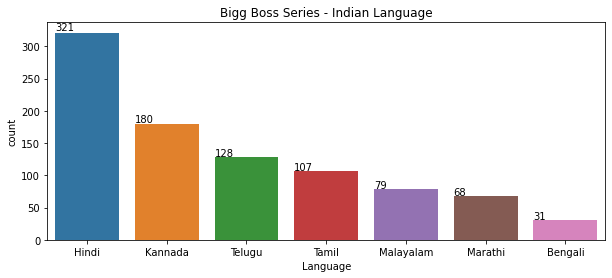

In [14]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10,4))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Language')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates entered in first day/week

No     779
Yes    135
Name: Wild Card, dtype: int64 

No     85%
Yes    15%
Name: Wild Card, dtype: object 



<AxesSubplot:xlabel='Wild Card', ylabel='count'>

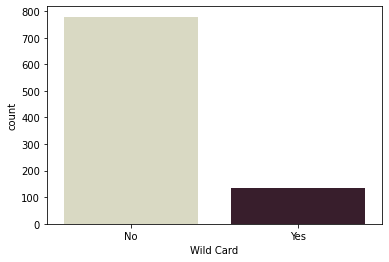

In [15]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")
sns.countplot(x='Wild Card', data=bigg_boss, palette="ch:.45")

In [16]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession']='Commoner'

## Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions

Actress                  201
Actor                    142
Soap Actress              78
Model                     66
Singer                    56
Soap Actor                49
Commoner                  41
Social Media Star         30
TV Anchor                 27
Reality Show Alumni       27
Comedian                  23
Radio Jockey              20
Choreographer             16
News Presenter            15
Sports Person              9
Activist                   9
Film Director              8
Pageant Winner             7
Video Jockey               7
International Star         6
Politician                 6
Producer                   5
Dancer                     5
LGBT                       4
Swamiji                    4
Controversial Fame         4
Musician                   3
Numerologist               3
Wrestler                   3
Stage Actress              2
Doctor                     2
Lyricist                   2
Entrepreneur               2
Journalist                 2
Film director 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 [Text(0, 0, 'Actress'),
  Text(1, 0, 'Actor'),
  Text(2, 0, 'Soap Actress'),
  Text(3, 0, 'Model'),
  Text(4, 0, 'Singer'),
  Text(5, 0, 'Soap Actor'),
  Text(6, 0, 'Commoner'),
  Text(7, 0, 'Social Media Star'),
  Text(8, 0, 'TV Anchor'),
  Text(9, 0, 'Reality Show Alumni'),
  Text(10, 0, 'Comedian'),
  Text(11, 0, 'Radio Jockey'),
  Text(12, 0, 'Choreographer'),
  Text(13, 0, 'News Presenter'),
  Text(14, 0, 'Sports Person'),
  Text(15, 0, 'Activist'),
  Text(16, 0, 'Film Director'),
  Text(17, 0, 'Pageant Winner'),
  Text(18, 0, 'Video Jockey'),
  Text(19, 0, 'International Star'),
  Text(20, 0, 'Politician'),
  Text(21, 0, 'Producer'),
  Text(22, 0, 'Dancer'),
  Text(23, 0, 'LGBT'),
  Text(24, 0, 'Swamiji'),
  Text(

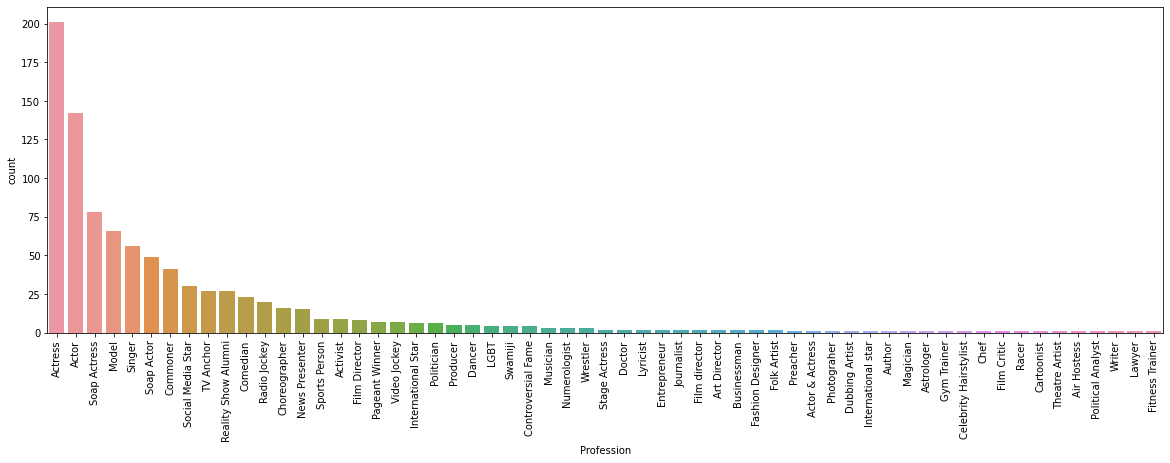

In [17]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20,6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(rotation=90)

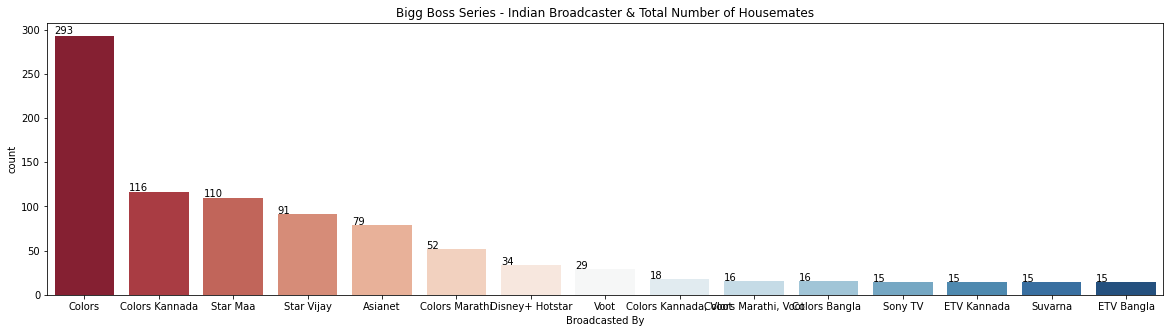

In [18]:
# Broadcaster
fig = plt.figure(figsize=(20,5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Broadcaster & Total Number of Housemates')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

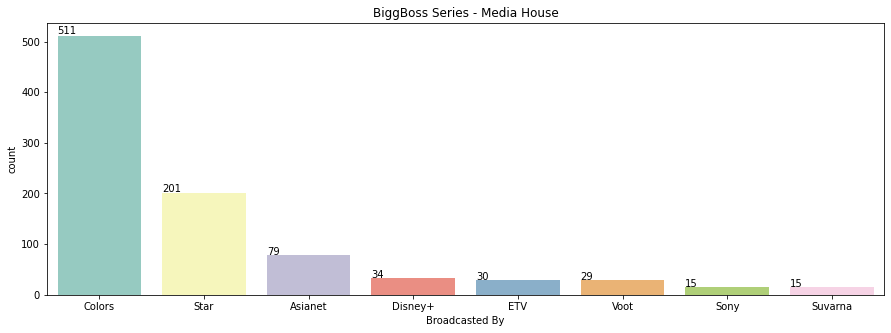

In [19]:
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(bigg_boss['Broadcasted By'].str.split().str.get(0), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).value_counts().index)
ax.set_title('BiggBoss Series - Media House')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [20]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            13
Sudeep                 10
Kamal Haasan            6
Nagarjuna               5
Mahesh Manjrekar        4
Mohanlal                4
Mithun Chakraborthy     2
Amitabh Bachchan        1
Arshad Warsi            1
Farah Khan              1
Jr. NTR                 1
Karan Johar             1
Nani                    1
Shilpa Shetty           1
Name: Season Number, dtype: int64

In [21]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Ramya Krishnan       2
Farah Khan           1
Samantha             1
Sanjay Dutt          1
Siddhartha Jadhav    1
Simbu                1
Name: Season Number, dtype: int64

## In all Bigg Boss competitions, in languages and in all seasons, Female contestants are more

Female         476
Male           431
Transgender      6
Couple           1
Name: Gender, dtype: int64 

Female         52%
Male           47%
Transgender     1%
Couple          0%
Name: Gender, dtype: object


<AxesSubplot:xlabel='Gender', ylabel='count'>

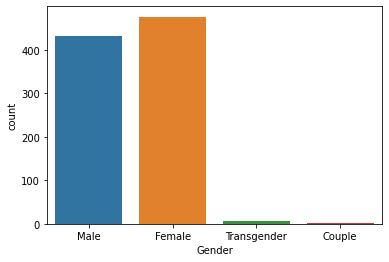

In [22]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

sns.countplot(data = bigg_boss, x = 'Gender')

### Only 6 Transgenders (LGBT) participated in all Indian languages

In [23]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP",bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.1 

Language Season Number
  Telugu             4


In [24]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season",bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

Smallest season 28 days 

Language Season Number
   Hindi     Halla Bol


In [25]:
# Longest season of Bigg Boss Indian seasons
print("Longest season",bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 143 days 

Language Season Number
   Hindi            14


In [26]:
print("Maximum number of contestants in one season:",bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum number of contestants in one season: 24.0 

Language Season Number
   Hindi            15


In [27]:
print("Maximum number of evictions faced in one season:",bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 3 contestants who faced maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-3][["Language","Season Number","Name","Number of Evictions Faced"]].head(3).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

Maximum number of evictions faced in one season: 17 


Top 3 contestants who faced maximum number of evictions

Language Season Number               Name  Number of Evictions Faced
   Hindi            14      Rubina Dilaik                         17
 Kannada             8 Prashanth Sambargi                         15
   Hindi            14       Rahul Vaidya                         14


In [28]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:",bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 3 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-5][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(3).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

Maximum percentage of evictions faced in one season: 100 %


Top 3 contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Language Season Number               Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
   Hindi     Halla Bol      Dimpy Ganguly                          4                       4                         100
 Kannada           OTT Jayashree Aradhaya                          6                       6                         100
   Tamil      Ultimate      Maria Juliana                         10                      10                         100


In [29]:
print("Maximum number of re-entries:",bigg_boss['Number of re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of re-entries']>=bigg_boss['Number of re-entries'].max()-1][["Language","Season Number","Name","Number of re-entries"]].head(5).sort_values("Number of re-entries",ascending=False).to_string(index=False))

Maximum number of re-entries: 3 

Language Season Number         Name  Number of re-entries
   Hindi            14  Vikas Gupta                     3
  Telugu             1 Mumaith Khan                     2
  Telugu             2  Nutan Naidu                     2


In [30]:
print("Maximum number of times elected as captain:",bigg_boss['Number of times elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of times elected as Captain']>=bigg_boss['Number of times elected as Captain'].max()-1][["Language","Season Number","Name","Number of times elected as Captain"]].head(6).sort_values("Number of times elected as Captain",ascending=False).to_string(index=False))

Maximum number of times elected as captain: 5 

 Language Season Number           Name  Number of times elected as Captain
    Hindi            12    Surbhi Rana                                   5
    Hindi             9  Prince Narula                                   4
    Hindi            10 Manveer Gurjar                                   4
Malayalam             2  Saju Navodaya                                   4


In [31]:
# Many contestants entered via wild card, but 19 people managed to go to Finale
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
44,Hindi,3,Pravesh Rana,Model,Male,NaT,NaT,12,Yes,84,15.0,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,0,<NA>,1,0.0,12,33
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,NaT,2011-01-08,14,Yes,96,16.0,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,2,0,2,<NA>,1,0.0,14,14
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,Yes,96,16.0,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,1,<NA>,1,0.0,14,29
75,Hindi,5,Amar Upadhyay,Actor,Male,NaT,2012-01-07,14,Yes,98,18.0,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,1,<NA>,1,0.0,14,50
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,NaT,2012-01-07,14,Yes,98,18.0,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,5,0,0,<NA>,1,0.0,14,36
77,Hindi,5,Akashdeep Saigal,Actor,Male,NaT,2012-01-07,14,Yes,98,18.0,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,5,0,1,<NA>,1,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19.0,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,1,1,<NA>,1,0.0,14,43
115,Hindi,7,Ajaz Khan,Actor,Male,NaT,2013-12-28,15,Yes,105,20.0,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,0,<NA>,1,0.0,15,47
133,Hindi,8,Ali Quli Mirza,Singer,Male,NaT,2015-01-03,15,Yes,105,19.0,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,1,<NA>,1,0.0,15,40
135,Hindi,8,Dimpy Ganguly,TV Anchor,Female,NaT,2015-01-03,15,Yes,105,19.0,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,5,0,1,<NA>,1,0.0,15,33


## About Winners only

In [32]:
print("Total Bigg Boss season winners",bigg_boss['Winner'].sum().astype(int), "(out of",bigg_boss['Finalist'].sum(),"finalists)")
# For Malayalam Season 2 winner was not declared

Total Bigg Boss season winners 46 (out of 224 finalists)


In [33]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,<NA>,No,86,15.0,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,0,<NA>,1,1.0,12,33
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,No,98,15.0,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,0,<NA>,1,1.0,14,29
42,Hindi,3,Vindu Dara Singh,Actor,Male,2009-10-04,NaT,<NA>,No,84,15.0,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,0,<NA>,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,2010-10-03,NaT,<NA>,No,96,16.0,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,2,<NA>,1,1.0,14,29
62,Hindi,5,Juhi Parmar,Soap Actress,Female,2011-10-02,NaT,<NA>,No,98,18.0,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,1,<NA>,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,2012-10-07,NaT,<NA>,No,97,19.0,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,1,<NA>,1,1.0,14,43
102,Hindi,7,Gauhar Khan,Actress,Female,2013-09-15,NaT,<NA>,No,105,20.0,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,2,<NA>,1,1.0,15,47
121,Hindi,8,Gautam Gulati,Actor,Male,2014-09-21,NaT,<NA>,No,105,19.0,2014-09-21,2015-01-03,Salman Khan,Farah Khan,5000000.0,Colors,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,10,0,1,<NA>,1,1.0,15,67
140,Hindi,Halla Bol,Gautam Gulati,Actor,Male,2015-01-04,NaT,<NA>,No,28,10.0,2015-01-04,2015-01-31,Farah Khan,NaN,5000000.0,Colors,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,2,0,0,<NA>,1,1.0,4,50
154,Hindi,9,Prince Narula,Reality Show Alumni,Male,2015-10-11,NaT,<NA>,No,105,20.0,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,4,<NA>,1,1.0,15,40


In [34]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 24 crores and 11 lakh rupees

₹24,11,00,000


In [35]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Profession'].value_counts()

Actor                  12
Soap Actress            7
Actress                 7
Singer                  4
Reality Show Alumni     3
Soap Actor              3
Commoner                2
TV Anchor               2
Model                   2
Film Director           1
Comedian                1
Radio Jockey            1
Video Jockey            1
Name: Profession, dtype: int64

Male      32
Female    14
Name: Gender, dtype: int64 

Male      %%
Female    %%
Name: Gender, dtype: object


<AxesSubplot:xlabel='Gender', ylabel='count'>

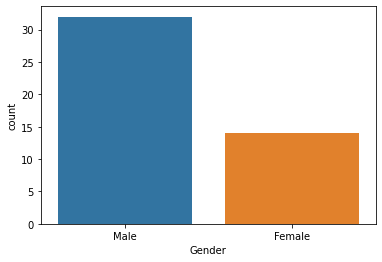

In [36]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts(),'\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

sns.countplot(data = bigg_boss.loc[bigg_boss.Winner==1], x = 'Gender')

## No wild card entry housemate won the Bigg Boss competition.

In [37]:
# Entry type of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Wild Card'].value_counts()

No    46
Name: Wild Card, dtype: int64

In [38]:
bigg_boss.loc[bigg_boss.Winner==1,'Season Length'].value_counts().sort_index()

# Length of the season - Number of Winners

28      1
42      2
70      2
84      2
86      1
90      1
95      1
96      1
97      2
98     11
100     1
105    12
106     2
112     2
113     1
117     1
121     1
140     1
143     1
Name: Season Length, dtype: int64

In [39]:
bigg_boss.loc[bigg_boss.Winner==1,'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

10.0    1
13.0    1
15.0    6
16.0    5
17.0    5
18.0    9
19.0    7
20.0    9
22.0    2
24.0    1
Name: Number of Housemates, dtype: int64

In [40]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1,'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

2     2
4     7
5     6
6     6
7     8
8     2
9     7
10    1
11    2
12    3
17    1
Name: Number of Evictions Faced, dtype: Int64

In [41]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1,'Number of re-entries'].value_counts()

0    46
Name: Number of re-entries, dtype: Int64

In [42]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1,'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain - Number of winners

0    14
1    14
2    13
3     1
4     2
Name: Number of times elected as Captain, dtype: Int64

## BB Marathi Seasons

In [43]:
lang='Marathi'

# All Bigg Boss Marathi Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
736,Marathi,1,Aarti Solanki,Comedian,Female,2018-04-15,NaT,1,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,1,0,0,<NA>,0,0.0,14,7
737,Marathi,1,Aastad Kale,Actor,Male,2018-04-15,NaT,14,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,7,0,1,<NA>,1,0.0,14,50
738,Marathi,1,Anil Thatte,Journalist,Male,2018-04-15,NaT,4,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,3,0,0,<NA>,0,0.0,14,21
739,Marathi,1,Bhushan Kadu,Actor,Male,2018-04-15,NaT,9,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,4,0,1,<NA>,0,0.0,14,29
740,Marathi,1,Jui Gadkari,Soap Actress,Female,2018-04-15,NaT,7,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,5,0,0,<NA>,0,0.0,14,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,Marathi,4,Tejaswini Lonari,Actress,Female,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",NaN,Maharashtra,No,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,14,<NA>
800,Marathi,4,Trishul Marathe,Commoner,Male,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",NaN,Maharashtra,No,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,14,<NA>
801,Marathi,4,Vikas Sawant,Choreographer,Male,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",NaN,Maharashtra,No,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,14,<NA>
802,Marathi,4,Yashashri Masurkar,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",NaN,Maharashtra,No,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,14,<NA>


In [44]:
# Bigg Boss Marathi Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
741,Marathi,1,Megha Dhade,Actress,Female,2018-04-15,NaT,<NA>,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,2500000.0,Colors Marathi,NaN,Maharashtra,No,5,0,2,<NA>,1,1.0,14,36
763,Marathi,2,Shiv Thakre,Reality Show Alumni,Male,2019-05-26,NaT,<NA>,No,98,17.0,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,2500000.0,Colors Marathi,NaN,Maharashtra,No,7,0,2,<NA>,1,1.0,14,50
785,Marathi,3,Vishal Nikam,Soap Actor,Male,2021-09-19,NaT,<NA>,No,98,17.0,2021-09-19,2021-12-26,Mahesh Manjrekar,Siddhartha Jadhav,2000000.0,Colors Marathi,NaN,Maharashtra,No,9,0,0,<NA>,1,1.0,14,64


In [45]:
# Marathi Bigg Boss all seasons finalists
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
737,Marathi,1,Aastad Kale,Actor,Male,2018-04-15,NaT,14,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,7,0,1,<NA>,1,0.0,14,50
741,Marathi,1,Megha Dhade,Actress,Female,2018-04-15,NaT,<NA>,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,2500000.0,Colors Marathi,NaN,Maharashtra,No,5,0,2,<NA>,1,1.0,14,36
742,Marathi,1,Pushkar Jog,Actor,Male,2018-04-15,NaT,14,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,5,0,2,<NA>,1,0.0,14,36
746,Marathi,1,Sai Lokur,Actress,Female,2018-04-15,NaT,14,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,7,0,2,<NA>,1,0.0,14,50
747,Marathi,1,Smita Gondkar,Actress,Female,2018-04-15,NaT,14,No,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,8,0,1,<NA>,1,0.0,14,57
751,Marathi,1,Sharmishtha Raut,Actress,Female,NaT,NaT,14,Yes,98,18.0,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,5,0,0,<NA>,1,0.0,14,36
757,Marathi,2,Kishori Shahane Vij,Actress,Female,2019-05-26,NaT,14,No,98,17.0,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,9,0,1,<NA>,1,0.0,14,64
760,Marathi,2,Neha Shitole,Actress,Female,2019-05-26,NaT,14,No,98,17.0,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,7,0,1,<NA>,1,0.0,14,50
763,Marathi,2,Shiv Thakre,Reality Show Alumni,Male,2019-05-26,NaT,<NA>,No,98,17.0,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,2500000.0,Colors Marathi,NaN,Maharashtra,No,7,0,2,<NA>,1,1.0,14,50
764,Marathi,2,Shivani Surve,Actress,Female,2019-05-26,NaT,3,No,98,17.0,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,Maharashtra,No,2,1,1,<NA>,1,0.0,14,14


In [46]:
# Number of finalists gender wise, in each BB Marathi season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Gender')['Season Number'].value_counts().sort_index()

# In first/second seasons, 4 Female and 2 Male finalists

Gender  Season Number
Female  1                4
        2                4
        3                1
Male    1                2
        2                2
        3                4
Name: Season Number, dtype: int64

In [47]:
# Bigg Boss Marathi current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']==3), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage


In [48]:
# Bigg Boss Marathi Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

Female    35
Male      33
Name: Gender, dtype: int64 



In [49]:
print("\nTop 3 Marathi contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang),'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-1)][["Season Number","Name","Number of Evictions Faced"]].head(6).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))


Top 3 Marathi contestants who faced maximum number of evictions

Season Number        Name  Number of Evictions Faced
            3 Vikas Patil                         11


In [50]:
print("\nTop 3 Marathi contestants who faced maximum percentage of evictions (they were in nominations for most number of weeks)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang),'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-10)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(6).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))


Top 3 Marathi contestants who faced maximum percentage of evictions (they were in nominations for most number of weeks)

Season Number        Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
            3 Vikas Patil                         11                      14                          79


## Preparing Data for ML modelling

In [51]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                            124
Elimination Date                      743
Elimination Week Number               190
Wild Card                               0
Season Length                           0
Number of Housemates                   16
Season Start Date                       0
Season End Date                         0
Host Name                               0
Guest Host Name                       788
Prize Money (INR)                      66
Broadcasted By                          0
Average TRP                           383
Most Viewed States                      0
OTT Season                              0
Number of Evictions Faced              53
Number of re-entries                   50
Number of times elected as Captain    103
Social Media Popularity           

In [52]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [53]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].fillna(0)

In [54]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            914 non-null    object        
 1   Season Number                       914 non-null    object        
 2   Name                                914 non-null    object        
 3   Profession                          914 non-null    object        
 4   Gender                              914 non-null    object        
 5   Entry Date                          790 non-null    datetime64[ns]
 6   Elimination Date                    171 non-null    datetime64[ns]
 7   Elimination Week Number             724 non-null    Int32         
 8   Wild Card                           914 non-null    object        
 9   Season Length                       914 non-null    int64         
 10  Number of Housemates      

In [55]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10,No,86,15.0,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3,0,0,<NA>,0,0.0,12,25,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5,No,86,15.0,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4,No,86,15.0,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Bobby Darling,LGBT,Transgender,2006-11-03,NaT,1,No,86,15.0,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,No,86,15.0,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,0,<NA>,1,0.0,12,50,2006,2007,4,1


In [56]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
909,Malayalam,4,Sooraj Thelakkad,Actor,Male,2022-03-27,NaT,14,No,98,20.0,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,5,0,2,<NA>,1,0.0,14,36,2022,2022,1,3
910,Malayalam,4,Suchithra Nair,Soap Actress,Female,2022-03-27,NaT,9,No,98,20.0,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,2,0,0,<NA>,0,0.0,14,14,2022,2022,1,3
911,Malayalam,4,Manikandan Thonnakkal,Social Media Star,Male,NaT,NaT,4,Yes,98,20.0,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,0,0,0,<NA>,0,0.0,14,0,2022,2022,1,3
912,Malayalam,4,Riyas Salim,Social Media Star,Male,NaT,NaT,14,Yes,98,20.0,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,4,0,1,7,1,0.0,14,29,2022,2022,1,3
913,Malayalam,4,Vinay Madhav,Social Media Star,Male,NaT,NaT,12,Yes,98,20.0,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,5,0,0,<NA>,0,0.0,14,36,2022,2022,1,3


In [57]:
# Updating last week-end elimination/entries manually
# bigg_boss.iloc[788,23] = 0

In [58]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
389,Kannada,5,Chandan Shetty,Singer,Male,2017-10-15,NaT,<NA>,No,106,20.0,2017-10-15,2018-01-28,Sudeep,NaN,5000000.0,Colors Kannada,8.707476,Karnataka,No,5,0,1,9,1,1.0,15,33,2017,2018,4,1
872,Malayalam,2,Pavan Gino Thomas,Model,Male,NaT,NaT,<NA>,Yes,75,23.0,2020-01-05,2020-03-20,Mohanlal,NaN,0.0,Asianet,11.030000,Kerala,No,0,0,0,<NA>,0,0.0,11,0,2020,2020,1,1
892,Malayalam,3,Angel Thomas,Model,Female,NaT,NaT,4,Yes,95,19.0,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.400000,Kerala,No,1,0,0,<NA>,0,0.0,14,7,2021,2021,1,2
224,Hindi,13,Abu Malik,Singer,Male,2019-09-29,NaT,3,No,140,22.0,2019-09-29,2020-02-15,Salman Khan,NaN,0.0,Colors,9.060000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,20,5,2019,2020,3,1
559,Telugu,4,Gangavva,Social Media Star,Female,2020-09-06,2020-10-10,5,No,105,19.0,2020-09-06,2020-12-20,Nagarjuna,Samantha,0.0,Star Maa,20.100000,"Telangana, Andhra Pradesh",No,2,0,1,7,0,0.0,15,13,2020,2020,3,4
762,Marathi,2,Rupali Bhosale,Soap Actress,Female,2019-05-26,NaT,10,No,98,17.0,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,0.0,Colors Marathi,8.707476,Maharashtra,No,4,0,1,<NA>,0,0.0,14,29,2019,2019,2,3
123,Hindi,8,Minissha Lamba,Actress,Female,2014-09-21,NaT,6,No,105,19.0,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.770000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3,0,0,<NA>,0,0.0,15,20,2014,2015,3,1
321,Kannada,1,Anushree,TV Anchor,Female,2013-03-24,NaT,11,No,98,15.0,2013-03-24,2013-06-30,Sudeep,NaN,0.0,ETV Kannada,4.700000,Karnataka,No,3,0,0,<NA>,0,0.0,14,21,2013,2013,1,2
405,Kannada,5,Lasya Nagaraj,Actress,Female,NaT,NaT,10,Yes,106,20.0,2017-10-15,2018-01-28,Sudeep,NaN,0.0,Colors Kannada,8.707476,Karnataka,No,1,0,0,<NA>,0,0.0,15,7,2017,2018,4,1
654,Tamil,2,Mumtaz,Actress,Female,2018-06-17,NaT,13,No,105,17.0,2018-06-17,2018-09-30,Kamal Haasan,NaN,0.0,Star Vijay,8.200000,Tamil Nadu,No,8,0,0,<NA>,0,0.0,15,53,2018,2018,2,3


In [59]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Marathi season

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
788,Marathi,4,Akshay Kelkar,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
789,Marathi,4,Amruta Deshmukh,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
790,Marathi,4,Amruta Dhongade,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
791,Marathi,4,Apurva Nemlekar,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
792,Marathi,4,Kiran Mane,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
793,Marathi,4,Megha Ghadge,Actress,Female,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
794,Marathi,4,Nikhil Rajeshirke,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
795,Marathi,4,Prasad Jawade,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
796,Marathi,4,Rohit Shinde,Model,Male,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1
797,Marathi,4,Ruchira Jadhav,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,16.0,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,NaN,14,<NA>,2022,2023,4,1


In [60]:
BB_marathi_participant = test[['Name']]
BB_marathi_participant.reset_index(drop=True, inplace=True)
BB_marathi_participant

,Name
0,Akshay Kelkar
1,Amruta Deshmukh
2,Amruta Dhongade
3,Apurva Nemlekar
4,Kiran Mane
5,Megha Ghadge
6,Nikhil Rajeshirke
7,Prasad Jawade
8,Rohit Shinde
9,Ruchira Jadhav


In [61]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date",], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [62]:
train.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,10,No,86,15.0,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3,0,0,<NA>,0,0.0,12,25,2006,2007,4,1
1,Hindi,1,Model,Female,5,No,86,15.0,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,4,No,86,15.0,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,LGBT,Transgender,1,No,86,15.0,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Model,Female,12,No,86,15.0,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,0,<NA>,1,0.0,12,50,2006,2007,4,1


In [63]:
test.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
788,Marathi,4,Soap Actor,Male,<NA>,No,98,16.0,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,14,<NA>,2022,2023,4,1
789,Marathi,4,Soap Actress,Female,<NA>,No,98,16.0,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,14,<NA>,2022,2023,4,1
790,Marathi,4,Soap Actress,Female,<NA>,No,98,16.0,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,14,<NA>,2022,2023,4,1
791,Marathi,4,Soap Actress,Female,<NA>,No,98,16.0,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,14,<NA>,2022,2023,4,1
792,Marathi,4,Soap Actor,Male,<NA>,No,98,16.0,Mahesh Manjrekar,NaN,NaN,"Colors Marathi, Voot",8.707476,Maharashtra,No,1,0,0,<NA>,<NA>,14,<NA>,2022,2023,4,1


In [64]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.575472
1.0     5.424528
Name: Winner, dtype: float64


In [65]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [66]:
print(train2.shape)
print(test.shape)

(848, 354)
(16, 354)


In [67]:
train2.isnull().sum().sort_values(ascending=False)

Language_Hindi                          0
Evictions Faced Percentage_13           0
Social Media Popularity_5               0
Social Media Popularity_4               0
Number of times elected as Captain_5    0
                                       ..
Season Length_105                       0
Season Length_100                       0
Season Length_98                        0
Season Length_97                        0
Season Ending Quarter_4                 0
Length: 354, dtype: int64

In [68]:
# train2.drop(["Number of Evictions Faced_15"], axis=1, inplace=True)
# test.drop(["Number of Evictions Faced_15"], axis=1, inplace=True)

In [69]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Season Number_15,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_Halla Bol,Season Number_Non-Stop,Season Number_OTT,Season Number_Ultimate,Profession_Actor,...,Season Starting Year_2019,Season Starting Year_2020,Season Starting Year_2021,Season Starting Year_2022,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Ending Year_2022,Season Ending Year_2023,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [70]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [71]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=2022)
print(x_train.shape, x_val.shape)

(593, 354) (255, 354)


In [72]:
x_train.isnull().sum().sort_values(ascending=False)

Language_Hindi                          0
Evictions Faced Percentage_13           0
Social Media Popularity_5               0
Social Media Popularity_4               0
Number of times elected as Captain_5    0
                                       ..
Season Length_105                       0
Season Length_100                       0
Season Length_98                        0
Season Length_97                        0
Season Ending Quarter_4                 0
Length: 354, dtype: int64

## Machine Learning Modelling

In [73]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues');
    ax.set_xlabel('True Label',size=12)
    ax.set_ylabel('Predicted Label',size=12)

In [74]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2021, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 94.15686274509804
F1 score for C=1: 96.81124975242624
F1 score for C=10: 97.36246725410813
F1 score for C=100: 97.87217118084556
F1 score for C=1000: 97.87217118084556


In [75]:
logi = LogisticRegression(random_state=2022, C=100).fit(x_train, y_train)
logi

LogisticRegression(C=100, random_state=2022)

In [76]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 97.6470588235294
Accuracy Score - 97.6470588235294


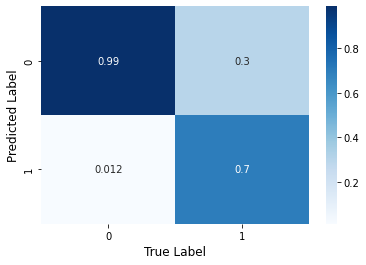

In [77]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 1

In [78]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_marathi_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
1,Amruta Deshmukh,0.000042
2,Amruta Dhongade,0.000042
3,Apurva Nemlekar,0.000042
9,Ruchira Jadhav,0.000042
14,Yashashri Masurkar,0.000042
12,Trishul Marathe,0.000010
5,Megha Ghadge,0.000010
11,Tejaswini Lonari,0.000010
15,Yogesh Jadhav,0.000009
8,Rohit Shinde,0.000009


## Predicted Winner for Bigg Boss Marathi Season 4, as per Logistic Regression

In [79]:
# Predicted Winner for Bigg Boss Marathi Season 4, as per LogisticRegression
winner_lg[winner_lg['Predicted_Winner'] == np.amax(winner_lg.Predicted_Winner)]

,Name,Predicted_Winner
1,Amruta Deshmukh,0.000042
2,Amruta Dhongade,0.000042
3,Apurva Nemlekar,0.000042
9,Ruchira Jadhav,0.000042
14,Yashashri Masurkar,0.000042


In [80]:
# Random Forest
rf = RandomForestClassifier(n_estimators=5000, random_state=2022).fit(x_train, y_train)
rf

RandomForestClassifier(n_estimators=5000, random_state=2022)

In [81]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=500 accuracy 98.5
# n_estimators=1000 accuracy 99.00

F1 Score - 97.52112227004622
Accuracy Score - 97.6470588235294


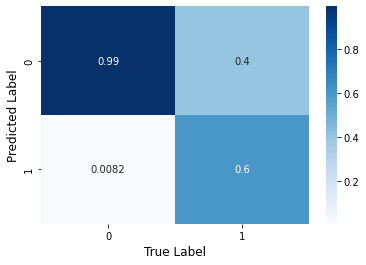

In [82]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 1

In [83]:
predicted_val_rf = rf.predict_proba(test)[:,1]
winner_rf = pd.concat([BB_marathi_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])],axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
1,Amruta Deshmukh,0.0088
2,Amruta Dhongade,0.0088
3,Apurva Nemlekar,0.0088
9,Ruchira Jadhav,0.0088
14,Yashashri Masurkar,0.0088
0,Akshay Kelkar,0.0036
4,Kiran Mane,0.0036
6,Nikhil Rajeshirke,0.0036
7,Prasad Jawade,0.0036
15,Yogesh Jadhav,0.0036


## Predicted Winner for Bigg Boss Marathi Season 4, as per Random Forest

In [84]:
# Predicted Winner for Bigg Boss Marathi Season 4, as per RandomForest
winner_rf[winner_rf['Predicted_Winner'] == np.amax(winner_rf.Predicted_Winner)]

,Name,Predicted_Winner
1,Amruta Deshmukh,0.0088
2,Amruta Dhongade,0.0088
3,Apurva Nemlekar,0.0088
9,Ruchira Jadhav,0.0088
14,Yashashri Masurkar,0.0088


## Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Hindi Bigg Boss Season15
## https://www.kaggle.com/thirumani/predicting-bigg-boss-hindi-season-15-winner

## Kannada Bigg Boss Season8
## https://www.kaggle.com/thirumani/predicting-bigg-boss-kannada-season-8-winner

## Telugu Bigg Boss Season5
## https://www.kaggle.com/thirumani/predicting-bigg-boss-telugu-season-5-winner

## Tamil Bigg Boss Season5
## https://www.kaggle.com/thirumani/predicting-bigg-boss-tamil-season-5-winner

## Malayalam Bigg Boss Season3
## https://www.kaggle.com/thirumani/predicting-bigg-boss-malayalam-season-3-winner

In [85]:
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width = 2000, height = 1500, background_color='white', colormap='Set3', collocations=False, random_state=2021).generate(text)
wordcloud.to_file("world_cloud_marathi.png")

<img src="./world_cloud_marathi.png">

In [86]:
print("Skewness: %f" % bigg_boss['Winner'].skew())
print("Kurtosis: %f" % bigg_boss['Winner'].kurt())

Skewness: 3.942984
Kurtosis: 13.579140


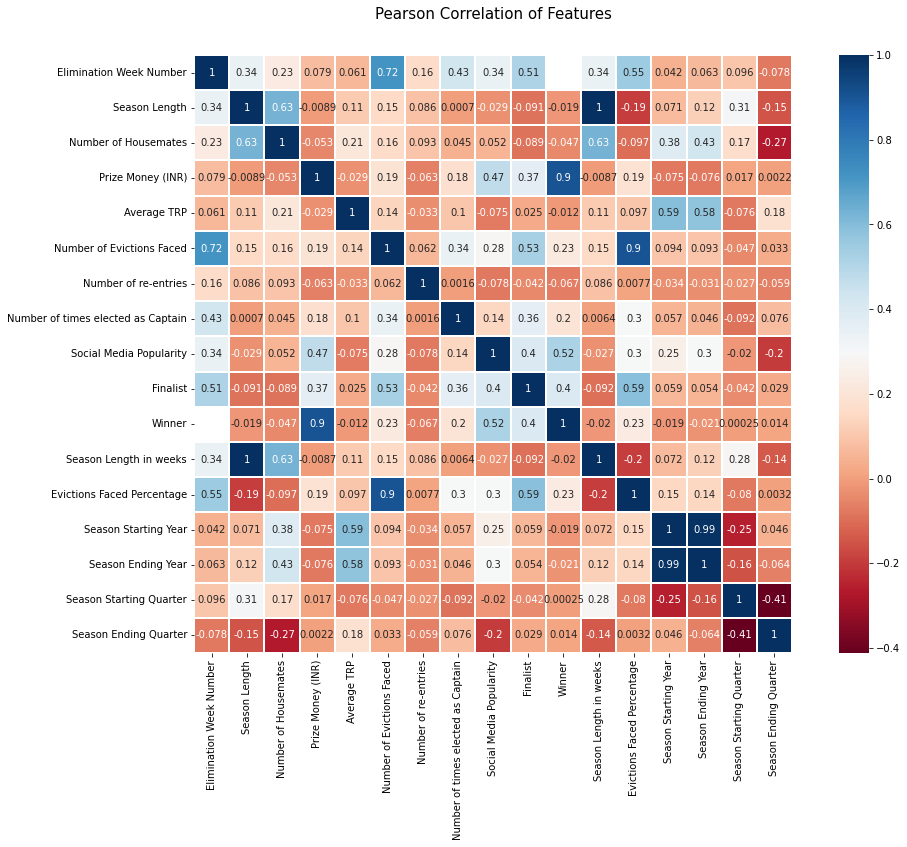

In [87]:
# Correlation matrix (Heatmap style)
corrmat = bigg_boss.corr()
f, ax = plt.subplots(figsize=(17, 11))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=True, cmap="RdBu", linecolor='white', annot=True);

In [88]:
# Crosschecking Actor/Actress Gender
bigg_boss[bigg_boss['Profession'].str.contains('Act')].groupby('Gender')['Profession'].value_counts().unstack()
#bigg_boss.loc[(bigg_boss['Profession']=='Actress') & (bigg_boss['Gender']=='Male')]

Profession,Activist,Actor,Actor & Actress,Actress,Soap Actor,Soap Actress,Stage Actress
Gender,,,,,,,
Couple,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Female,4.0,NaN,NaN,201.0,NaN,78.0,2.0
Male,5.0,142.0,NaN,NaN,49.0,NaN,NaN


In [89]:
#sns.pairplot(bigg_boss, diag_kind='hist', hue='Winner', palette='seismic')

In [90]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))

import matplotlib
print("matplotlib version: {}". format(matplotlib. __version__))
print("seaborn version: {}". format(sns.__version__))

import sklearn
print("sklearn version: {}". format(sklearn.__version__))

# Versions as of September 2022
# numpy version: 1.21.6
# pandas version: 1.3.5
# matplotlib version: 3.5.3
# seaborn version: 0.11.2
# sklearn version: 1.0.2

numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.5.3
seaborn version: 0.11.2
sklearn version: 1.0.2
